<a href="https://colab.research.google.com/github/wisemanam/NIHLungNet/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Lung Disease Using CNNs

In [3]:
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa
import pandas as pd
import keras
from keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import categorical_accuracy

## Loading in the Data

In [2]:
data_path = '/content/drive/MyDrive/data/xray_data/'
train_path = data_path + 'train/'
test_path = data_path + 'test/'

In [12]:
df = pd.read_csv(data_path + "Data_Entry_2017.csv")
df["Finding Labels"]=df["Finding Labels"].apply(lambda x:x.split("|"))
classes = ["No Finding", 
           "Atelectasis", 
           "Consolidation", 
           "Infiltration",
           "Pneumothorax",
           "Edema",
           "Emphysema",
           "Fibrosis",
           "Effusion",
           "Pneumonia",
           "Pleural_Thickening",
           "Cardiomegaly",
           "Mass",
           "Nodule",
           "Hernia"]

datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

# using 15000/86524 training images
train_it=datagen.flow_from_dataframe(dataframe=df, 
                                            directory=train_path, 
                                            x_col="Image Index", 
                                            y_col="Finding Labels", 
                                            batch_size=32, 
                                            seed=42, 
                                            shuffle=True, 
                                            class_mode="categorical",
                                            classes=classes,
                                            target_size=(1024,1024))

# using 2000/~20000 testing images
test_it=test_datagen.flow_from_dataframe(dataframe=df,
                                                directory=test_path,
                                                x_col="Image Index",
                                                y_col="Finding Labels",
                                                batch_size=214,
                                                seed=42,
                                                shuffle=False,
                                                class_mode="categorical",
                                                classes=classes,
                                                target_size=(1024,1024))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 89060 invalid image filename(s) in x_col="Image Index". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 23060 validated image filenames belonging to 15 classes.
Found 3210 validated image filenames belonging to 15 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 108910 invalid image filename(s) in x_col="Image Index". These filename(s) will be ignored.
  .format(n_invalid, x_col)


## Creating the Model
Next, I am going to create the model that will train on the Chest X-Rays. I am going to start with a pre-trained network and see if that helps training go more smoothly. I am using categorical crossentropy as my loss function to allow for multiple labels being present. I also use sigmoid activation to accommodate multiple labels. 

In [4]:
from tensorflow_addons.metrics import HammingLoss
# load model without classifier layers
model = DenseNet121(include_top=False, input_shape=(1024, 1024, 3), weights='imagenet', pooling='max')

# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='sigmoid')(flat1)
output = Dense(15, activation='sigmoid')(class1)

# define new model
model = Model(inputs=model.inputs, outputs=output)

for layer in model.layers[:-4]:
    layer.trainable=False

optimizer = keras.optimizers.Adam(lr=0.00001)
model.compile(loss=[tfa.losses.SigmoidFocalCrossEntropy(gamma=4.0)], metrics=[HammingLoss(mode='multiclass', threshold=0.7)], optimizer=optimizer)
history1 = model.fit(train_it, batch_size=256, epochs=10, validation_data=test_it)


29089792/29084464 [==============================] - 0s 0us/step
Epoch 1/10
721/721 [==============================] - 10625s 15s/step - loss: 0.1401 - hamming_loss: 0.9985 - val_loss: 0.1266 - val_hamming_loss: 1.0000
Epoch 2/10
721/721 [==============================] - 997s 1s/step - loss: 0.0837 - hamming_loss: 1.0000 - val_loss: 0.1238 - val_hamming_loss: 1.0000
Epoch 3/10
721/721 [==============================] - 988s 1s/step - loss: 0.0798 - hamming_loss: 1.0000 - val_loss: 0.1213 - val_hamming_loss: 1.0000
Epoch 4/10
721/721 [==============================] - 984s 1s/step - loss: 0.0775 - hamming_loss: 1.0000 - val_loss: 0.1178 - val_hamming_loss: 1.0000
Epoch 5/10
721/721 [==============================] - 986s 1s/step - loss: 0.0765 - hamming_loss: 1.0000 - val_loss: 0.1177 - val_hamming_loss: 1.0000
Epoch 6/10
721/721 [==============================] - 981s 1s/step - loss: 0.0765 - hamming_loss: 1.0000 - val_loss: 0.1184 - val_hamming_loss: 1.0000
Epoch 7/10
721/721 [======

KeyError: ignored

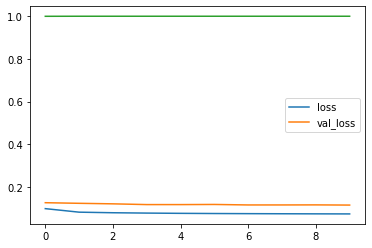

In [6]:
plt.plot( history1.epoch,history1.history['loss'], label = 'loss' )
plt.plot( history1.epoch,history1.history['val_loss'], label = 'val_loss' )
plt.legend()

plt.plot( history1.epoch,history1.history['hamming_loss'], label = 'hamming_loss' )
plt.plot( history1.epoch,history1.history['val_hamming_loss'], label = 'val_hamming_loss' )
plt.legend()

In [7]:
model.evaluate(test_it)

3210/3210 [==============================] - 140s 44ms/step - loss: 0.1155 - hamming_loss: 1.0000


[0.11547640711069107, 1.0]

In [14]:
def get_batch_scores(labels, pred_labels):
  batch_size = len(labels)
  num_classes = len(labels[0])

  accuracy_sum = 0
  precision_sum = 0
  recall_sum = 0

  accuracy_by_class = []
  precision_by_class = []
  recall_by_class = []

  for j in range(num_classes): # for each class
    tp_count = 0
    fn_count = 0
    fp_count = 0
    num_correct = 0
    for i in range(batch_size): # for each image in batch
      # counts number of correct predictions
      if pred_labels[i][j] == labels[i][j]:
        num_correct += 1

      # counts number of true positives
      if pred_labels[i][j] == 1 and labels[i][j] == 1:
        tp_count += 1

      # counts number of false negatives
      elif pred_labels[i][j] == 0 and labels[i][j] == 1:
        fn_count += 1
      
      # counts number of false positives
      elif pred_labels[i][j] == 1 and labels[i][j] == 0:
        fp_count += 1

    # gets the sum of all the scores in the batch
    accuracy_sum += num_correct/15
    if (tp_count + fp_count) != 0:
      precision_sum += tp_count/(tp_count + fp_count)
    if (tp_count + fn_count) != 0:
      recall_sum += tp_count/(tp_count + fn_count)

    # averages the score across the batch by dividing by the batch size
    accuracy_by_class.append(accuracy_sum/batch_size)
    precision_by_class.append(precision_sum/batch_size)
    recall_by_class.append(recall_sum/batch_size)

  # returns average scores across the batch
  return accuracy_by_class, precision_by_class, recall_by_class

In [2]:
accuracies = []
precisions = []
recalls = []

for batch in test_it:
  images = batch[0]
  labels = batch[1]
  print('Images shape:', images.shape)
  print('Labels shape:', labels.shape)
  # print('true_labels: \n', labels)
  pred = model.predict(images)
  pred_labels = 1*(pred>0.5)
  # print('pred_labels: \n', pred_labels)

  # gets average scores from the batch
  batch_accuracy, batch_precision, batch_recall = get_batch_scores(labels, pred_labels) 
  accuracies.append(batch_accuracy)
  precisions.append(batch_precision)
  recalls.append(batch_recall)

# averages the scores of all the batches
accuracies = [sum(x) / len(x) for x in zip(*accuracies)]
precisions = [sum(x) / len(x) for x in zip(*precisions)]
recalls = [sum(x) / len(x) for x in zip(*recalls)]

print('Accuracy: ', accuracies)
print('Precision: ', precisions)
print('Recall: ', recalls)


NameError: ignored

In [ ]:
while True:pass